1. Представлен пайплайн с 40 фанфиками, время исполнения которого занимает около часа. В полном датасете ~5000 фанфиков.
2. Написана автоматическая загрузка датасета в блокнот, для удобства воспроизводимости (replicability) исследования
3. В пайплайн подключено обучение word2vec и построение лингвистического графа, написанные ранее
4. В пайплайн собраны шаги предобработки, выделения именованных сущностей, составление графа взаимодействия персонажей, написанные ранее

# **PREPROCESSING**

Загрузка датасета фанфика из репозитория на GitHub, перемещение его в отдельно созданные папки

In [1]:
!curl https://raw.githubusercontent.com/KarinaZakirova/diploma_work_2024/main/src/getting_texts_with_origs/fandoms.zip > fandoms.zip
!curl https://raw.githubusercontent.com/KarinaZakirova/diploma_work_2024/main/src/getting_texts_with_origs/origs.zip > origs.zip
!mkdir                datasets/

!rm -rf               datasets/fandoms/
!mkdir                datasets/fandoms/
!unzip fandoms.zip -d datasets/fandoms/ &> /dev/null
!rm    fandoms.zip

!rm -rf               datasets/origs/
!mkdir                datasets/origs/
!unzip origs.zip   -d datasets/origs/   &> /dev/null
!rm    origs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4934k  100 4934k    0     0  9986k      0 --:--:-- --:--:-- --:--:--  9.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6096k  100 6096k    0     0  14.8M      0 --:--:-- --:--:-- --:--:-- 14.8M


Установка модели spacy для русского языка и установка pymorphy для лемматизации текста


In [2]:
!python -m spacy download ru_core_news_lg &> /dev/null
!pip install pymorphy3 &> /dev/null

Лемматизация текста

In [3]:
import spacy
import os
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from pathlib import Path
import re

from pymorphy3 import MorphAnalyzer

# nlp = spacy.load("ru_core_news_lg")
# nlp.max_length = 4000000

ORIGIN = Path("datasets")
DEST = ORIGIN / "lemmatized"

lemmatizer = MorphAnalyzer()

 Создаем отдельную папку для лемматизированных фанфиков. Открываем фанфик, ищем все слова в тексте при помощи регулярного выражения, лемматизируем при помощи pymorphy, записываем результат в отдельный файл. Повторяем результат для всех файлов в подгруженном датасете.

In [4]:
def lemmatize(filename, genre):
    dest_filename = DEST / genre / filename.name
    if dest_filename.exists():
        return
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = re.findall("\w+", text)
    if len(tokens) > 100000:
        print(len(tokens))
    lemmas = [lemmatizer.parse(token)[0].normal_form for token in tokens]
    if not os.path.exists(DEST / genre):
        os.makedirs(DEST / genre)
    with open(dest_filename, 'w', encoding='utf-8') as f:
        f.write(' '.join(lemmas))
    # return doc

GENRES = ["origs", "fandoms"]
for genre in GENRES:
    filenames = list((ORIGIN / genre).glob("*.txt"))
    print(f"total {genre}: {len(filenames)}")
    for file in tqdm(filenames):
        lemmatize(file, genre)

total origs: 20


 40%|████      | 8/20 [02:06<03:21, 16.80s/it]

121268


 50%|█████     | 10/20 [03:06<03:53, 23.34s/it]

198448


 80%|████████  | 16/20 [05:34<01:20, 20.18s/it]

167428


 90%|█████████ | 18/20 [06:31<00:45, 22.94s/it]

318912


100%|██████████| 20/20 [08:09<00:00, 24.47s/it]


total fandoms: 20


 30%|███       | 6/20 [01:57<04:48, 20.57s/it]

151584


 35%|███▌      | 7/20 [02:41<06:05, 28.15s/it]

154663


 70%|███████   | 14/20 [05:20<01:48, 18.05s/it]

101878


100%|██████████| 20/20 [07:29<00:00, 22.48s/it]


# **LINGUISTIC GRAPH**

In [5]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

Создаем класс загрузки лемматизированных фанфиков, обучаем на них word2vec модель и сохраняем ее

In [6]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(GENRES, leave=True):
            for file in tqdm(os.listdir('datasets/lemmatized/' + genre), leave=False):
                if ".txt" not in file:
                    continue
                with open('datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    # use this when training
                    yield utils.simple_preprocess(f.read())
sentences = Dataloader()

word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)
word2vec.save('word2vec_model')
word2vec = gensim.models.Word2Vec.load('word2vec_model')


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Пересоздаем класс загрузки данных, дополняем его, чтобы он возвращал не только сам текст, но и его жанр (orig, fandom), создаем экземпляр класса и вызываем обученную нами модель

In [8]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(GENRES, leave=True):
            for file in tqdm(os.listdir('datasets/lemmatized/' + genre), leave=False):
                if ".txt" not in file:
                    continue
                with open('datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    # use this when graphing
                    yield utils.simple_preprocess(f.read()), genre
sentences = Dataloader()

wv = word2vec.wv

Построение лингвистического графа:
1. проходимся циклом по текстам датасета
2. находим 10 самых частотных слов данного текста
3. проходимся циклом по частотным словам
4. для каждого из слов находим ближайшие к нему слова при помощи word2vec

Ближайшие друг к другу слова — вершины графа.
Если между словами есть связь, то между ними строится грани графов

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

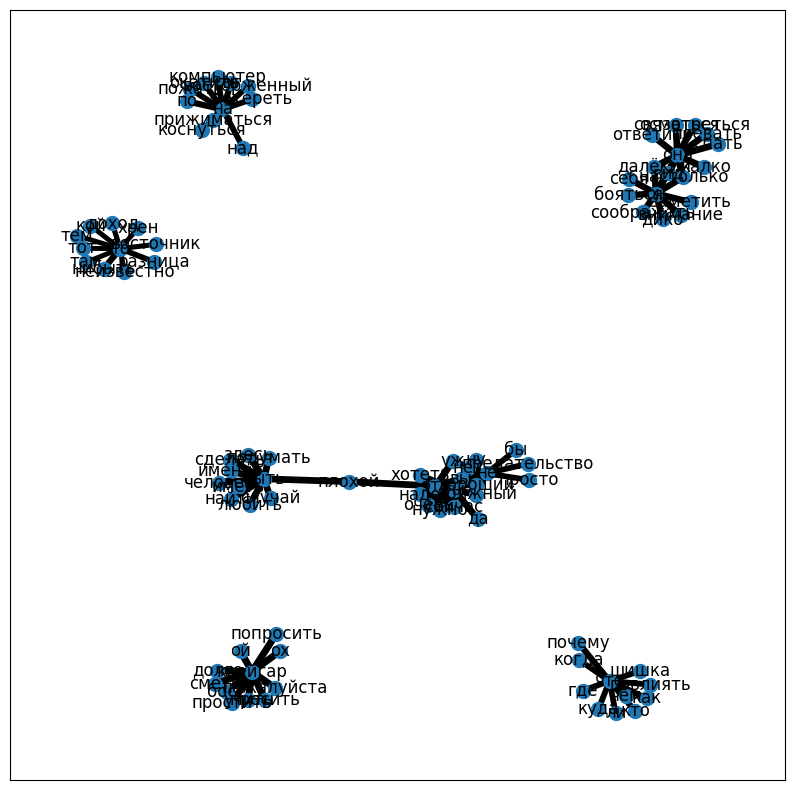

In [9]:
graphs = []
text_len = []
true_labels = []

for num_sentence, (sentence, genre) in enumerate(sentences):

    if not sentence:
        continue
    true_labels.append(genre)
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[-1])

weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))
nx.draw_networkx(graph, node_size=100, width=(weights + 0.5)**4)

# **CHARACTER GRAPH**

In [10]:
from os import listdir
from itertools import zip_longest, groupby
from pymystem3 import Mystem
from spacy.matcher import Matcher

nlp = spacy.load("ru_core_news_lg")
nlp.max_length = 4000000
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [11]:
!mkdir datasets/entities
!mkdir datasets/entities/origs
!mkdir datasets/entities/fandoms

!mkdir datasets/ner
!mkdir datasets/ner/origs
!mkdir datasets/ner/fandoms

!mkdir datasets/graph
!mkdir datasets/graph/origs
!mkdir datasets/graph/fandoms

!mkdir datasets/plots
!mkdir datasets/plots/origs
!mkdir datasets/plots/fandoms

Выделение именованных сущностей в текстах нашего датасета при помощи spacy

In [12]:
def extract_entities(
        in_dir="fanfics/",
        out_dir="entities/",
    ):
    for index, filename in enumerate(listdir(in_dir)):
        print(index, "extracting entities:", filename)

        if filename in listdir(out_dir):
            continue

        # Read fanfic, extract named entities
        with open(in_dir + filename, encoding='utf8') as f:
            text = f.read()
            named_entities = sorted(set(named_entity_recognition(text)), key=len, reverse=True)

        # Save entities
        with open(out_dir + filename, "w", encoding="utf-8") as f:
            f.write("\n".join(named_entities))

def named_entity_recognition(a):
    doc = nlp(a)
    named_entities = []

    for ent in doc.ents:
        if ent.label_ == "PER":

            named_entities.append(ent.text.replace('\n', " "))
    return named_entities


В текстах фанфиков отдельно выделяем именованные сущности при помощи тегов <>

In [13]:
def corpus_markup(
        text_dir="fanfics/",
        entity_dir="entities/",
        out_dir="ner/",
    ):
    for index, filename in enumerate(listdir(entity_dir)):
        print(index, "adding markup:", filename)

        if filename in listdir(out_dir):
            continue

        # Read fanfic
        with open(text_dir + filename, encoding='utf8') as f:
            text = f.read()

        # Load entities
        with open(entity_dir + filename, encoding="utf-8") as f:
            named_entities = f.read().split("\n")

        # Use entities to add markup
        with open(out_dir + filename, "w", encoding="utf-8") as f:
            for entity in named_entities:
                # Add brackets around every entity.
                # Ordered in the correct way to avoid doubling up or incomplete selections
                text = re.sub(f"(?<!<)({re.escape(entity)}[а-я]*)", r"<\g<1>>", text)
                # Remove bizarre empty marking. I don't know how and why it exists
                text = text.replace("<>", "")
            f.write(text)

1. Проходимся циклом по всему датасету (по всем фанфикам, главам в них, предложениям в них), проверяем предложения, если они имеют чрезмерно большое количество выделенных сущностей, то такое предложение отбрасывается (так как вероятнее всего произошла ошибка на стадии обработки текста/выделения именованных сущностей). Создаем словарь именованных сущностей

2. Отбрасываем недостаточно частотные сущности (если они встречаются меньше двух раз, то построить граф в нашем пайплайне с данной именованной сущностью не выйдет)

3. Вновь проходимся циклом по нашему датасету (предложениям в нем), смотрим на то, какие именованные сущности встречаются в одном предложении вместе, записываем такие пары сущностей как пары субъект-объект

4. При помощи функции extract_predicate выделяем глагол из предложения с нашей парой, с его помощью создаем триплет *субъект-предикат-объект*

Этот алгоритм не минималистичен, поскольку в его выполнение входит некоторая чистка данных для повышенияя качества итогового графа


In [14]:
def knowledge_graph(
        text_dir="ner/",
        entity_dir="entities/",
        out_dir="graph/",
    ):
    for key, group in iter_fanfics(entity_dir, out_dir):
        #iterate all tags and remember nonerroneous
        multipage_tags = []
        for text in iter_chapters(text_dir, group):
            for sentence in iter_sentences(text):
                print(sentence)
                lemmatised = "".join(mystem.lemmatize(sentence))
                print(lemmatised)
                if tags := extract_tags(lemmatised):
                    if len("".join(tags))/len(sentence) > 0.5 and len(sentence.split()) > 10:
                        # These are sentences which erroneously received
                        # an unusually high number of tags. Skip them.
                        continue


                    multipage_tags.extend(tags)
        counted_tags = Counter(multipage_tags)

        counted_tags = {k: v for k, v in counted_tags.items() if v > 2}

        tag_groups = []
        # find all relevant triplet
        for text in iter_chapters(text_dir, group):
            for sentence in iter_sentences(text):
                lemmatised = "".join(mystem.lemmatize(sentence))
                tags = extract_tags(lemmatised)
                relevant_tags = set(counted_tags) & set(tags)
                if len(relevant_tags) > 1:
                    subj, obj, *_ = relevant_tags
                    if predicate := extract_predicate(sentence):
                        triplet = (subj, predicate, obj)
                        tag_groups.append(triplet)

        counted_tag_groups = Counter(tag_groups)
        with open(out_dir + key, "w", encoding="utf-8") as f:
            write = csv.writer(f, dialect='unix')
            for index, tag in enumerate(sorted(counted_tag_groups, key=counted_tag_groups.get, reverse=True)):
                print(tag)
                write.writerow(tag)

def iter_fanfics(entity_dir, out_dir):
    for key, group in groupby(listdir(entity_dir), lambda x: x[:7]):
        group = list(group)
        # if len(group) > 1:
        #     print(key, len(list(group)))
        print("===============================")
        print(key)

        if key in listdir(out_dir):
            continue
        yield key, group


def iter_chapters(text_dir, group):
    for filename in group:
        # print("===============================")
        # print(key, filename)
        with open(text_dir + filename, "r", encoding="utf-8") as f:
            yield f.read()


def iter_sentences(text):
    text = re.split('\.|!|\?', text)
    for sentence in text:
        yield sentence


def extract_tags(lemmatised):
    return [tag for tag in re.findall("\<(.*?)\>", lemmatised) if tag]


def extract_predicate(sentence):
    #find predicate in sentence
    predicate = get_relation(sentence.replace("<", "").replace(">", ""))
    if not predicate:
        return
    predicate = mystem.lemmatize(predicate)[0]
    if len(predicate) < 3:
        return
    if predicate[-2:] not in ("ть", "ти", "чь", "ся"):
        return
    return predicate


При помощи паттернов в синтаксисе находим предикат в предложении

In [15]:
def get_relation(sent):

    doc = nlp(sent)

    # Объект класса Matcher
    matcher = Matcher(nlp.vocab)

    # Режим определения
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},
               {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    if not matches:
        return
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

Отрисовка итогового графа взаимодействия персонажей:
1. из полученных в предыдущем шаге триплетов субъект-предикат-объект создаем pandas DataFrame.
2. при помощи библиотеки networkx на основе pandas DataFrame строится сам граф
3. методами из библиотеки matplotlib отрисовываем граф  

In [16]:
import networkx as nx
import pandas as pd
import csv
import matplotlib.pyplot as plt
from os import listdir

def iter_csv_graphs(graph_dir="graph/", plot_dir="plots/"):
    for path in listdir(graph_dir):
        print(path)
        print("=========")
        if path in listdir(plot_dir):
            continue
        with open(graph_dir + path, encoding='UTF-8') as f:
            triplets = list(csv.reader(f))
            if not triplets:
                continue
            yield path, triplets

def get_edge_labels(triplets):
    return {(subj, obj): predicate for subj, predicate, obj in triplets}

def draw_graphs(graph_dir, plot_dir):
    for filename, triplets in iter_csv_graphs(graph_dir, plot_dir):
        subj, predicate, obj = zip(*triplets)

        kg_df = pd.DataFrame({'source':subj, 'target':obj, 'edge':predicate})

        print(kg_df)

        # Создание ориентированного графа из кадра данных
        G=nx.from_pandas_edgelist(kg_df, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

        plt.figure(figsize=(12,12))

        pos = nx.spring_layout(G)
        nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=get_edge_labels(triplets),
            font_color='indigo'
        )
        plt.show()
        break
        plt.savefig(f"{plot_dir}{filename}.png")


Вызов пайплайна создания графов на базе нашего датасета

Выходные данные были обрезаны до нескольких последних строк (5000).
 Для полноценного отдыха мне требовалось пару дней поспать в тепле, сытой и расслабленной, но кто меня спрашивал, что мне нужно
 для полноценный отдых я требоваться пара день поспать в тепло, сытый и расслабленный, но кто я спрашивать, что я нужно

 Вместо мягкой постели я довольствовалась голой землёй или, что бывало гораздо реже, ветками; вместо крыши над головой — натянутым между камнями плащом; вместо вкусной и сытной пищи — редкими перекусами тем, что можно было поймать или собрать по дороге
 вместо мягкий постель я довольствоваться голый земля или, что бывало гораздо редко, ветка; вместо крыша над голова — натянутый между камень плащ; вместо вкусный и сытный пища — редкий перекус то, что можно быть поймать или собирать по дорога

 С едой в караване старались обходиться экономно, выдавали небольшие пайки, опасаясь, что из-за рано наступившей осени с провизией будет туго
 с еда в караван стараться обходиться эконом

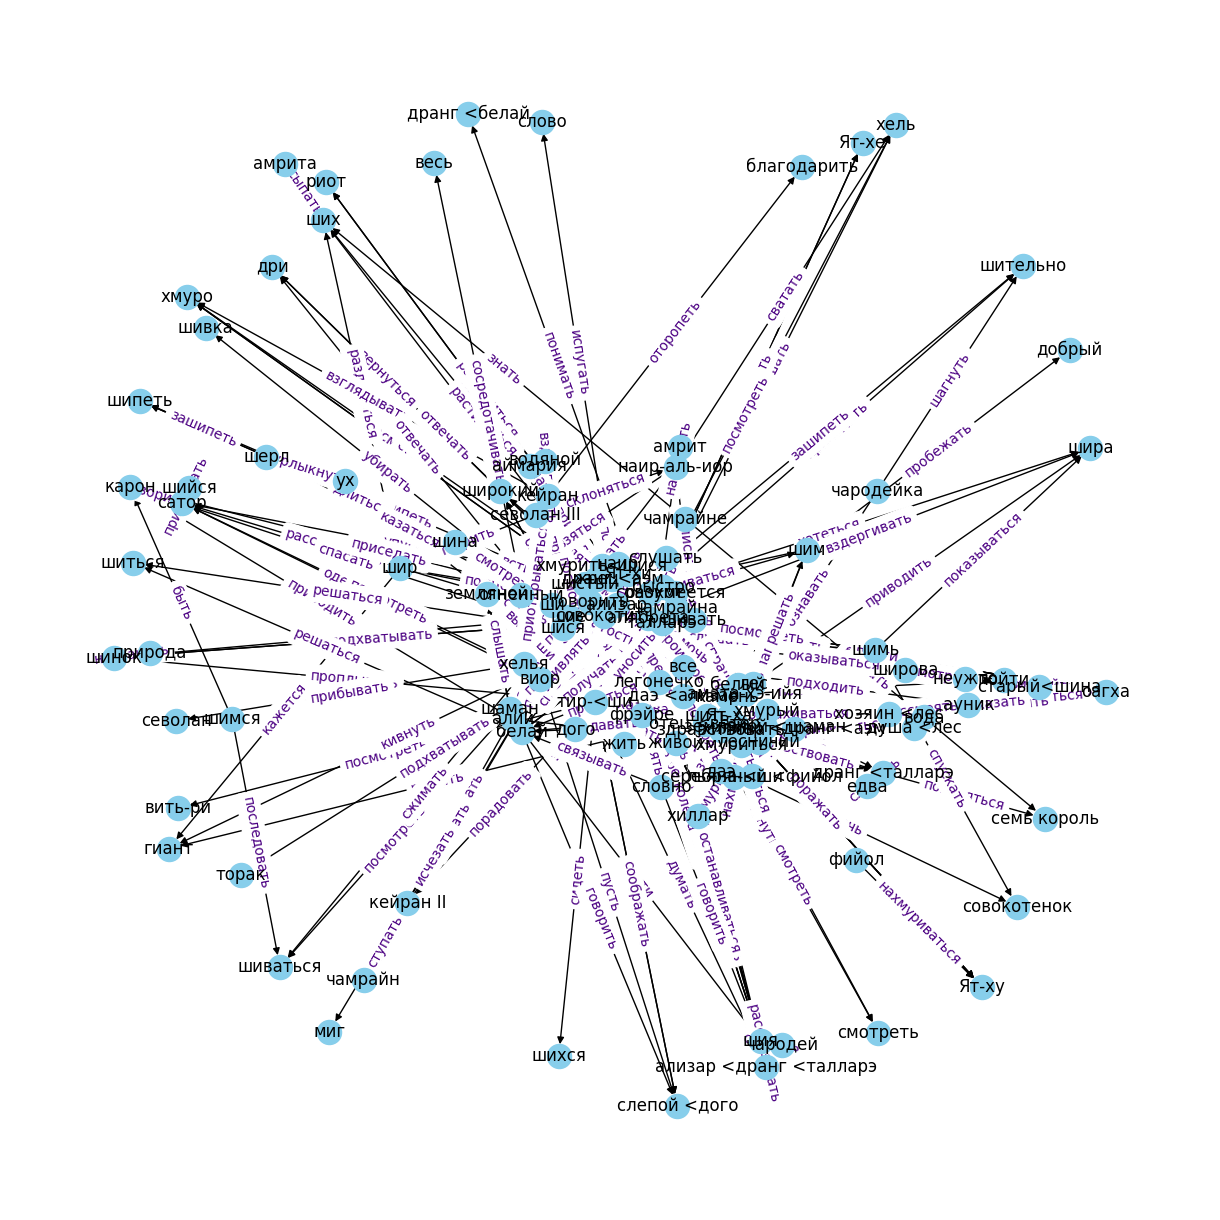

Выходные данные были обрезаны до нескольких последних строк (5000).
 раздаваться резкий металлический звон

 <Виверна> кричит в ответ, скалясь
 <виверна> кричать в ответ, скалиться

 <Стивен> создаёт вокруг кулаков сферы
 <стивен> создавать вокруг кулак сфера

 <Пёрл> крутит копьё и стреляет в виверну
 <перл> крутить копье и стрелять в виверна

 Та ревёт и с треском ломает дерево, срываясь к ним
 тот реветь и с треск ломать дерево, срываться к они

 <Гарнет> прыгает навстречу, целясь в голову, но виверна резко изворачивает шею, раскрывая пасть и готовясь съесть <Гарнет>
 <гарнет> прыгать навстречу, целиться в голова, но виверна резко изворачивать шея, раскрывать пасть и готовиться съедать <гарнет>

 Но та резко против, поэтому ударяет по верхнему нёбу
 но тот резко против, поэтому ударять по верхний небо

 <Виверна> скулит, резким взмахом крыльев уходя в небо
 <виверна> скулить, резкий взмах крыло уходить в небо

 <Пёрл> продолжает осыпать её выстрелами, от которых в высоте виверна лег

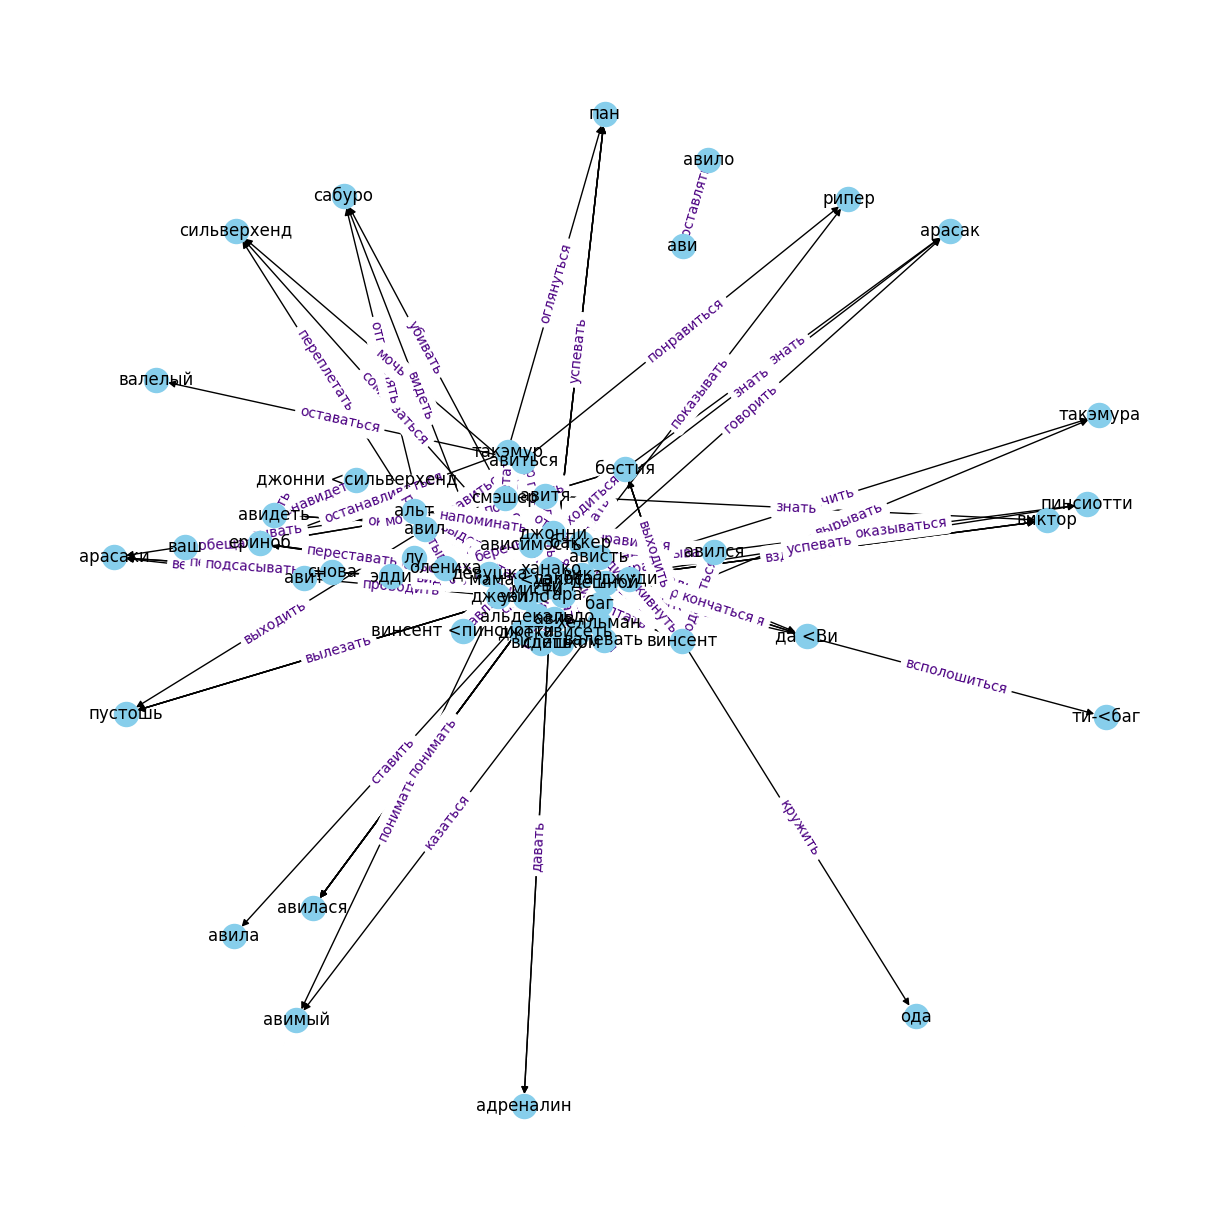

In [17]:
for genre in GENRES:
    extract_entities(
        f"datasets/{genre}/",
        f"datasets/entities/{genre}/",
    )
    corpus_markup(
        f"datasets/{genre}/",
        f"datasets/entities/{genre}/",
        f"datasets/ner/{genre}/",
    )
    knowledge_graph(
        f"datasets/ner/{genre}/",
        f"datasets/entities/{genre}/",
        f"datasets/graph/{genre}/",
    )
    draw_graphs(
        f"datasets/graph/{genre}/",
        None,
    )